In [9]:
import requests
import numpy as np
import datetime
from datetime import  timedelta
import matplotlib.pyplot as plt
import pandas as pd
import statistics
from ttide.t_tide import t_tide

In [10]:
def tide_extract(code,timestart,days=30):#timestop):#,days):
  print('Please wait, connecting to the server... \n')
  ## Este es el codigo para descargar datos, ojo en algunos casos puede no funcionar ... 
 #Function to extract tide gauge data in a station from IOC level Monitoring (http://www.ioc-sealevelmonitoring.org)
  #in automatic way (Web Scrapping).
  #arguments:
  #code      : station code (extracted from IOC webpage), example: 'coqu'
  #timestart : initial time (date, UTC) of the record, examples: '2010-02-27','27/02/2010','2010-02-27 06:30','27/02/2010 06:30'  
  #days      : number of days from timestart (default value = 30 days)
  #timestop  : final time (date, UTC) of the record, example: '2010-03-02' (no implemented yet)
  #Constraints: 30 days is the maximum length record allowed.
  #IOC site will only allow 30 days download at a time
  #If you want to add more records, use thsi function recurrsivelly and then concatenate.
  #version 1.0
  def try_parsing_date(text):
    for fmt in ('%Y-%m-%d','%Y-%m-%d %H:%M','%Y-%m-%d %H:%M:%S','%d/%m/%Y','%d/%m/%Y %H:%M','%d/%m/%Y %H:%M:%S'):
        try:
            return datetime.datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')
  timestart = try_parsing_date(timestart)
  timestop = timestart + datetime.timedelta(days=days)
  inputs = {'query':'data', 'format':'ascii', 'code':code, 'timestart':timestart, 'timestop':timestop}
  response = requests.get('http://www.ioc-sealevelmonitoring.org/service.php?', params=inputs, timeout=20)
  aux_file = open('aux_mareas.txt','w')
  aux_file.write(response.text)
  aux_file.close()
  raw_data = np.loadtxt('aux_mareas.txt',skiprows=1,dtype={'names': ('C1', 'C2', 'C3', 'C4'),'formats': ('float', 'U10', 'U8', 'S4')})
  sensor = raw_data['C4']
  Ntot = len(sensor)
  list_sensors = list(set(sensor))
  print('Select sensor: \n')
  for i in range(len(list_sensors)):
    print(str(i+1)+'. ', list_sensors[i].decode())
  selected = int(2) #Linea original :  selected = int(input())
  ind_sensor = np.where(sensor == list_sensors[selected-1])
  eta_tide  = raw_data['C1'][ind_sensor]
  date_a = raw_data['C2'][ind_sensor]
  date_b = raw_data['C3'][ind_sensor]
  date = np.char.add(date_a,' ')
  date = np.char.add(date,date_b)
  time = [datetime.datetime.strptime(date[i], "%Y-%m-%d %H:%M:%S") for i in range(len(date))]
  return time, eta_tide, list_sensors[selected-1].decode()

In [3]:
#Creamos una lista con todas las fechas necesarias
# Fecha de inicio
fecha_inicio = datetime.datetime(2021, 10, 31)
fecha_fin = datetime.datetime(2024, 3, 1)

# Lista para almacenar las fechas
fechas = []

# Agregar la fecha de inicio a la lista
fechas.append(fecha_inicio.strftime('%d/%m/%Y %H:%M:%S'))

# Generar las fechas cada 30 días
while fecha_inicio <= fecha_fin: #Cambiar año
    fecha_inicio += timedelta(days=30)
    fechas.append(fecha_inicio.strftime('%d/%m/%Y %H:%M:%S'))

# Imprimir la lista de fechas
#print(fechas)

In [4]:
eta_total = np.array([])
t_total = np.array([])
nombre = np.array([])

for i in fechas:
    print(i)
    t , eta, nombre_sensor = tide_extract('boye', i, days=30)
    t_total = np.concatenate((t_total, t))
    eta_total = np.concatenate((eta_total, eta))
    nombre = np.append(nombre, nombre_sensor)

31/10/2021 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
30/11/2021 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
30/12/2021 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
29/01/2022 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
28/02/2022 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
30/03/2022 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
29/04/2022 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
29/05/2022 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
28/06/2022 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
28/07/2022 00:00:00
Please wait, connecting to the server... 

Select sensor: 

1.  prs
2.  rad
27/08/2022 00:00:00
Please wait, connect

C:\Users\pedro\AppData\Local\Temp\ipykernel_10144\1200172815.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


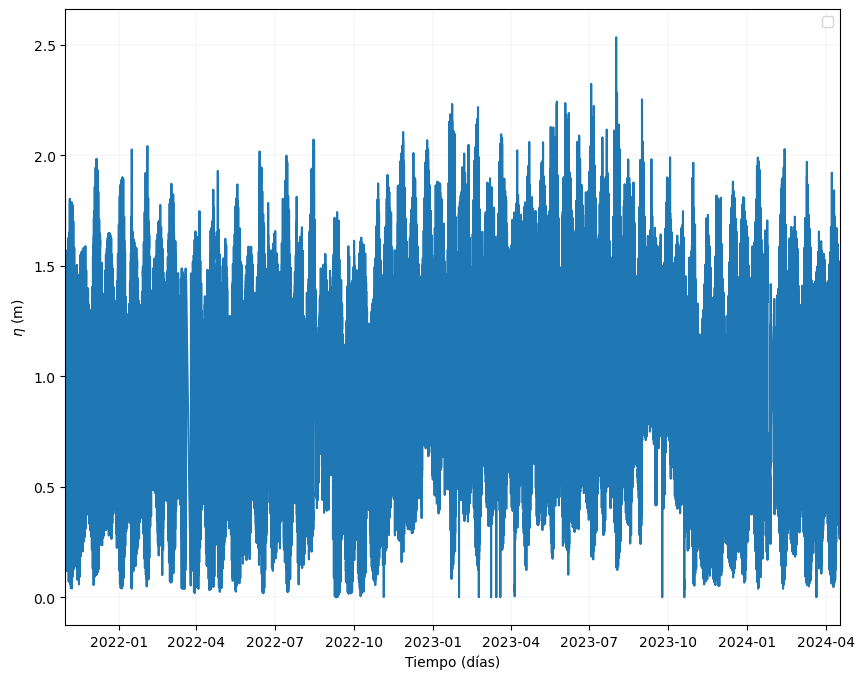

[1.091 0.967 0.932 ... 1.245 1.168 1.164]


In [5]:
#Graficamos los datos obtenidos del SHOA
fig = plt.figure(figsize=(10,8))

plt.plot(t_total,eta_total)
plt.xlim(t_total[0],t_total[-1])
plt.xlabel('Tiempo (días)')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='lightgray', linestyle='--', linewidth=0.25)
plt.show()

print(eta_total)

In [6]:
#Se creara un archivo para poder trabajar con el. 
#Se utilizara el sensor prs. tiene major resolución auqnue muy poca diferencia

tiempo = pd.Series(t_total, name='serie_tiempo')
eta = pd.Series(eta_total, name='serie_eta')

data_prs = pd.DataFrame({'Fecha': tiempo, 'Elevacion': eta})

nombre_archivo = 'boyeruca_2021-2024.csv'

data_prs.to_csv(nombre_archivo, index=False)

#Ojo que los niveles de marea estan en valores absolutos. 
#Tendremos que obtener la media y poner ese valor como referencial en el programa.

In [11]:
# Si los datos ya estan descargados, COMENZAR ACA
# Importamos el archivo y ajustaremos las elevaciones a nieveles relativos (valor - media)

datos = pd.read_csv('boyeruca_2021-2024.csv')

media = statistics.mean(datos['Elevacion'])
# Ajustar eta restando la media
datos['Elevacion'] = datos['Elevacion'] - media

# Convertir la columna 'Fecha' a objetos datetime si aún no lo están
datos['Fecha'] = pd.to_datetime(datos['Fecha'])

# Filtrar datos para conservar solo los registros correspondientes a los minutos 00, 15, 30 y 45
datos_filtrados = datos[datos['Fecha'].dt.minute % 15 == 0]

# Definir la fecha de inicio y finalización
inicio = datetime.datetime(2021, 10, 31, 0, 0, 0)
fin = datetime.datetime(2024, 3, 1, 20, 8, 0)
dt = 0.25 # [horas]

# Definir el intervalo de tiempo (15 minutos)
intervalo = timedelta(minutes=15)

# Lista para almacenar los vectores de tiempo
vector_tiempo = []

# Generar los vectores de tiempo
while inicio <= fin:
    vector_tiempo.append(inicio)
    inicio += intervalo

#Definir los valores nulos a NaN
#datos['indice'] = pd.to_datetime(datos[['Año', 'Mes', 'Dia', 'Hora', 'Minutos', 'Segundos']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H-%M-%S')
#datos = datos.drop(['Año', 'Mes', 'Dia', 'Hora', 'Minutos', 'Segundos'], axis=1)
datos.set_index('Fecha', inplace=True)
datos = datos[~datos.index.duplicated(keep='first')]
datos = datos.reindex(vector_tiempo)

#Agregarle el vector juliano
datos['Tiempo'] = vector_tiempo

datos_interpolados = datos.interpolate()

C:\Users\pedro\AppData\Local\Temp\ipykernel_14592\3496659701.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


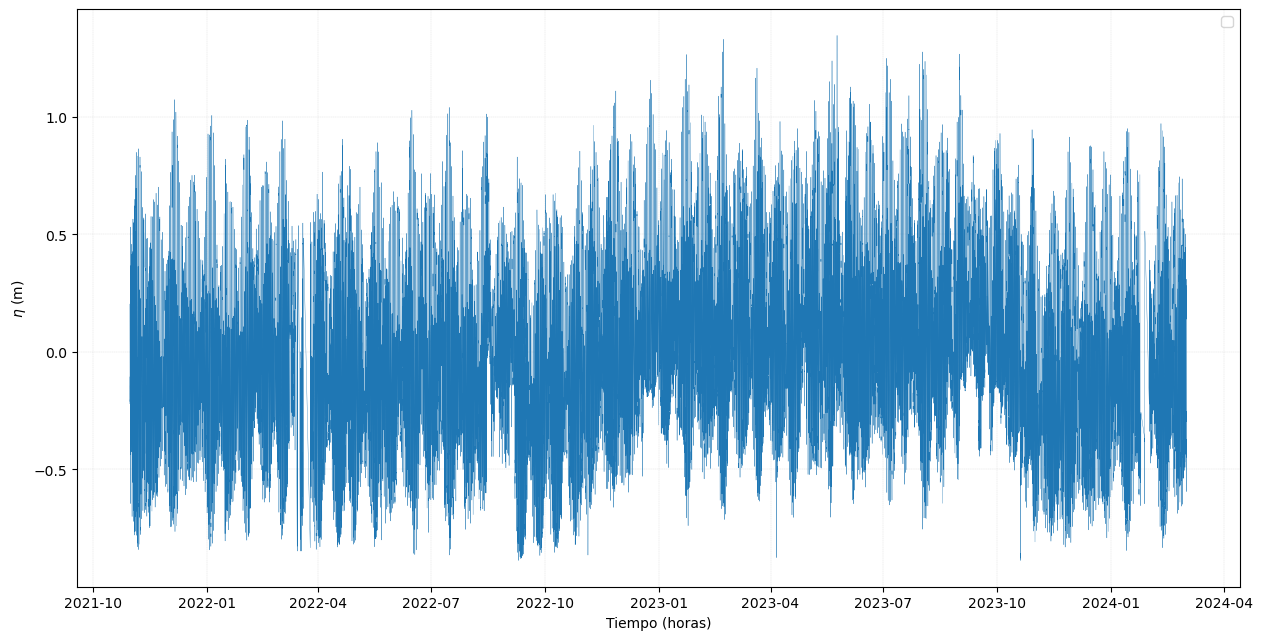

In [12]:
alto  = 7.5
ancho = 15
fig = plt.figure(figsize=(ancho, alto))

plt.plot(datos_interpolados['Tiempo'], datos_interpolados['Elevacion'], linewidth =0.25)
plt.xlabel('Tiempo (horas)')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='lightgray', linestyle='--', linewidth=0.25)
plt.show()

In [13]:
#Corremos el modelo TTIDE

inicio_mareas = datetime.datetime(2021, 10, 31)

eta = datos_interpolados['Elevacion']
eta = np.array(eta)

tide_fit = t_tide(eta, dt=0.25, stime=fin, synth=0)

c:\Users\pedro\miniforge3\envs\coastsat\Lib\site-packages\ttide-0.3.dev1-py3.11.egg\ttide\t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1


-----------------------------------
nobs = 81873 
ngood = 81873 
record length (days) = 852.84
start time: 2024-03-01 20:08:00
rayleigh criterion = 1.0

Greenwich phase computed, no nodal corrections
x0= 0.00806  xtrend= 0
var(data)= 0.14    var(prediction)= 0.12    var(residual)= 0.02
var(prediction)/var(data) (%) = 83.9

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0403     0.021    270.41     35.24       3.6
* SSA   0.0002282     0.0372     0.023    146.64     31.51       2.7
* MSM   0.0013098     0.0129     0.021    301.73    103.32      0.37
* MM    0.0015122     0.0026     0.016    143.25    217.94     0.026
* MSF   0.0028219     0.0130     0.017      7.96     95.44      0.58
* MF    0.0030501     0.0123     0.019    268.11    104.39       0.4
* ALP1  0.0343966     0.0017     0.002     43.35     99.93      0.66
* 2Q1   0.0357064     0.0029     0.003    206.72     40.22       1.2


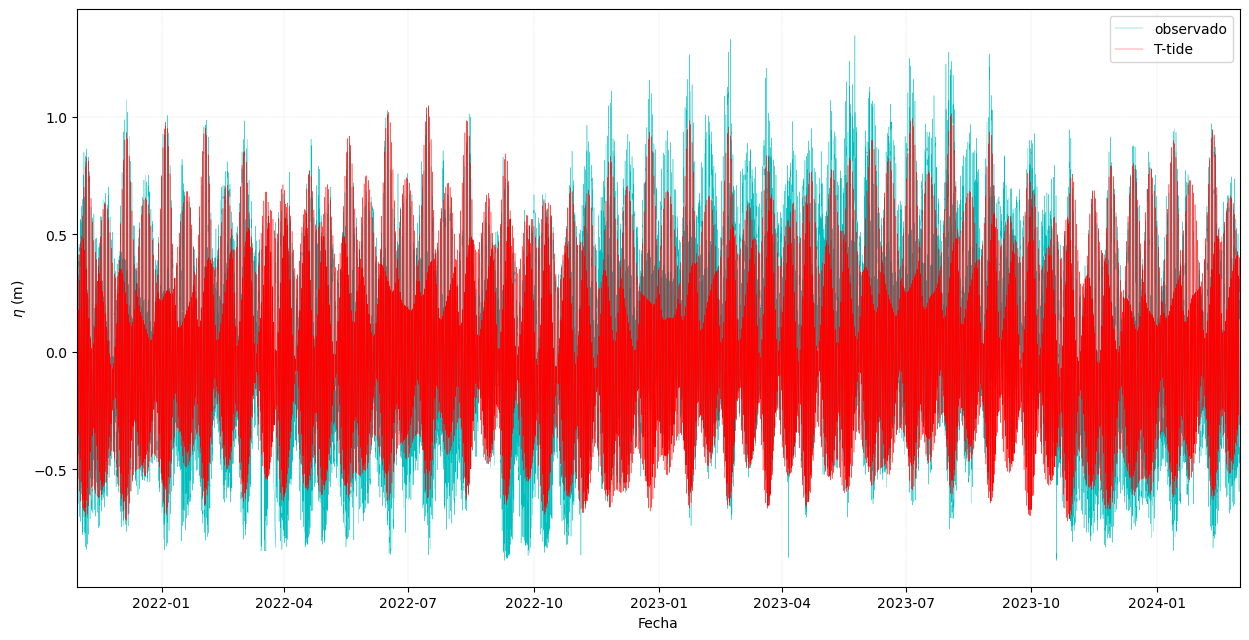

In [14]:
eta_ttide = tide_fit['xout'].squeeze()

fig = plt.figure(figsize=(15, 7.5))

plt.plot(vector_tiempo, eta,'c',linewidth=0.25,label='observado')
plt.plot(vector_tiempo, eta_ttide,'r',linewidth=0.25,label='T-tide')
plt.xlim(vector_tiempo[0],vector_tiempo[-1])
plt.xlabel('Fecha')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='lightgray', linestyle='--', linewidth=0.25)
plt.show()

In [15]:
#Extrapolamos la marea para todo el periodo de imagenes satelitales

# Definir la fecha de inicio y finalización
start = datetime.datetime(1985, 1, 25, 0, 0, 0)
finish = datetime.datetime(2024, 12, 31, 0, 0, 0)

# Definir el intervalo de tiempo (15 minutos)
interval = timedelta(minutes=15)

# Lista para almacenar los vectores de tiempo
tiempo = []

# Generar los vectores de tiempo
while start <= finish:
    tiempo.append(start)
    start += interval

eta_extrapolada = tide_fit(np.array(tiempo))

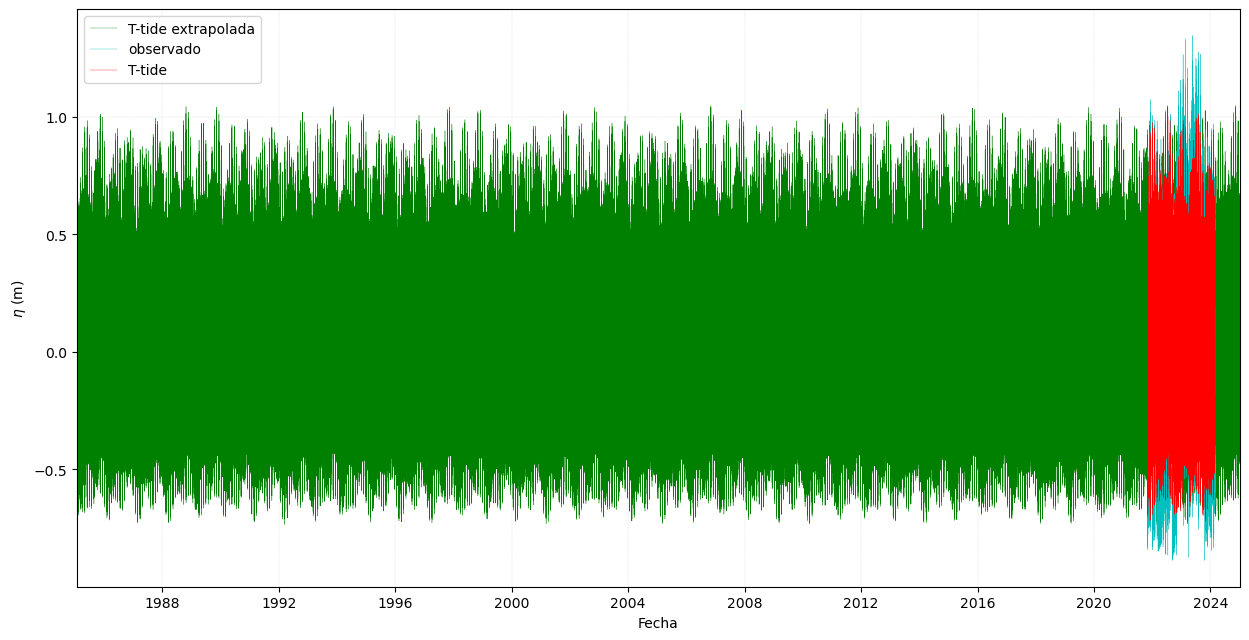

In [16]:
fig = plt.figure(figsize=(15, 7.5))

plt.plot(tiempo, eta_extrapolada,'g',linewidth=0.25,label='T-tide extrapolada')
plt.plot(vector_tiempo, eta,'c',linewidth=0.25,label='observado')
plt.plot(vector_tiempo, eta_ttide,'r',linewidth=0.25,label='T-tide')
plt.xlim(tiempo[0], tiempo[-1])
plt.xlabel('Fecha')
plt.ylabel('$\eta$ (m)')
plt.legend()
plt.grid(color='lightgray', linestyle='--', linewidth=0.25)
plt.show()

In [17]:
data_extrapolada = {
    'date' : tiempo,
    'tide': eta_extrapolada
}

df_data_extrapolada = pd.DataFrame(data_extrapolada)

df_data_extrapolada.to_csv('mareas_boyeruca_final.csv', index=False)